<a href="https://colab.research.google.com/github/young-hwanlee/my-practical-statistics-for-data-scientists/blob/main/Chapter_5_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Clone the repository
# !git clone https://github.com/young-hwanlee/practical-statistics-for-data-scientists.git

# # Open the file from the list of contents (File)
# # Then, copy and paste it

## Practical Statistics for Data Scientists (Python)
## Chapter 5. Classification
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

In [2]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 6.8 MB/s 


In [3]:
!pip install dmba

     |████████████████████████████████| 11.8 MB 7.5 MB/s 


Import required Python packages.

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm
from pygam import LinearGAM, s, f, l
from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


no display found. Using non-interactive Agg backend


In [5]:
# try:
#     import common
#     DATA = common.dataDirectory()
# except ImportError:
#     DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [6]:
# LOAN3000_CSV = DATA / 'loan3000.csv'
# LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
# FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'

DATA = 'https://raw.githubusercontent.com/young-hwanlee/practical-statistics-for-data-scientists/master/data/'

LOAN3000_CSV = DATA + 'loan3000.csv'
LOAN_DATA_CSV = DATA + 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA + 'full_train_set.csv.gz'

# **5.1 Naive Bayes**
## **5.1.2 The Naive Solution**


In [7]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

In [8]:
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [9]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])

loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

In [10]:
print(set(loan_data.outcome))
print(set(loan_data.purpose_))
print(set(loan_data.home_))
print(set(loan_data.emp_len_))

{'default', 'paid off'}
{'debt_consolidation', 'medical', 'credit_card', 'home_improvement', 'other', 'major_purchase', 'small_business'}
{'MORTGAGE', 'OWN', 'RENT'}
{' < 1 Year', ' > 1 Year'}


In [11]:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

In [12]:
X

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
0,0,0,0,1,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,1,0,1,0,0,1
2,0,0,0,0,0,1,0,0,0,1,0,1
3,0,1,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
45337,1,0,0,0,0,0,0,0,0,1,0,1
45338,0,0,0,0,0,1,0,1,0,0,0,1
45339,0,1,0,0,0,0,0,1,0,0,0,1
45340,0,1,0,0,0,0,0,1,0,0,0,1


In [13]:
X.loc[146]

credit_card           0
debt_consolidation    0
home_improvement      0
major_purchase        0
medical               0
other                 0
small_business        1
MORTGAGE              1
OWN                   0
RENT                  0
 < 1 Year             0
 > 1 Year             1
Name: 146, dtype: uint8

In [14]:
X.loc[146:146, :]

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
146,0,0,0,0,0,0,1,1,0,0,0,1


In [15]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
# naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


In [16]:
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted probabilities
    default  paid off
0  0.653696  0.346304


In [17]:
naive_model.classes_

array(['default', 'paid off'], dtype='<U8')

In [18]:
naive_model.class_count_

array([22671., 22671.])

In [19]:
print(naive_model.feature_names_in_)
print(naive_model.feature_count_)

['credit_card' 'debt_consolidation' 'home_improvement' 'major_purchase'
 'medical' 'other' 'small_business' 'MORTGAGE' 'OWN' 'RENT' ' < 1 Year'
 ' > 1 Year']
[[ 3435. 13052.  1356.   845.   325.  2621.  1037.  9779.  1888. 11004.
   1072. 21599.]
 [ 4253. 12518.  1621.  1215.   323.  2265.   476. 11097.  1834.  9740.
    704. 21967.]]


In [20]:
print(np.sum(naive_model.feature_count_[0]))
print(np.sum(naive_model.feature_count_[1]))

68013.0
68013.0


### **Example not in book**

Numerical variables are not supported in scikit-learn. The example would need to demonstrate binning a variable and display the probability distribution of the bins.

```
## example not in book
less_naive <- NaiveBayes(outcome ~ borrower_score + payment_inc_ratio + 
                           purpose_ + home_ + emp_len_, data = loan_data)
less_naive$table[1:2]

png(filename=file.path(PSDS_PATH, 'figures', 'psds_naive_bayes.png'),  width = 4, height=3, units='in', res=300)

stats <- less_naive$table[[1]]
ggplot(data.frame(borrower_score=c(0,1)), aes(borrower_score)) +
  stat_function(fun = dnorm, color='blue', linetype=1, 
                arg=list(mean=stats[1, 1], sd=stats[1, 2])) +
  stat_function(fun = dnorm, color='red', linetype=2, 
                arg=list(mean=stats[2, 1], sd=stats[2, 2])) +
  labs(y='probability')
dev.off()
```

## **5.2 Discriminant Analysis**
Both PCA and LDA are linear transformation techniques. However, PCA is an unsupervised while LDA is a supervised dimensionality reduction technique.

### **5.2.3 A Simple Example**

In [21]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')
# loan3000.outcome.cat.reorder_categories(['paid off', 'default'])

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [22]:
X

,borrower_score,payment_inc_ratio
0,0.40,5.11135
1,0.40,5.43165
2,0.70,9.23003
3,0.40,2.33482
4,0.45,12.10320
...,...,...
2995,0.50,18.36620
2996,0.60,1.80421
2997,0.20,15.42180
2998,0.45,8.92335


In [23]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


### **Figure 5.1**

In [24]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope   # y-intercept

# slope = - loan_lda.scalings_[1] / loan_lda.scalings_[0]
# intercept = center[0] - center[1] * slope   # y-intercept

print(center)
print(loan_lda.scalings_)
print(slope)
print(intercept)

[0.50093515 8.16350619]
[[ 7.1758388 ]
 [-0.09967559]]
[71.99193766]
[-27.89978562]


In [25]:
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [26]:
# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio,default
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135,0.553544
1,16982,default,credit_card,15.49,0.40,5.43165,0.558953
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003,0.272696
3,34580,paid off,major_purchase,21.11,0.40,2.33482,0.506254
4,14424,default,debt_consolidation,16.46,0.45,12.10320,0.609952


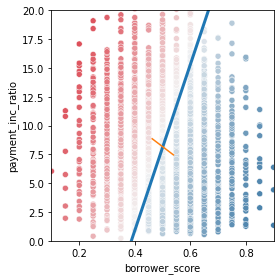

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
# ax.set_xlim(0.15, 0.8)
ax.set_xlim(0.1, 0.9)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

In [28]:
loan_lda.means_

array([[0.46280277, 8.86181347],
       [0.53906752, 7.4651989 ]])

In [29]:
loan_lda.means_.transpose()

array([[0.46280277, 0.53906752],
       [8.86181347, 7.4651989 ]])

## **5.3 Logistic regression**
### **5.3.1 Logistic Response Function and Logit**

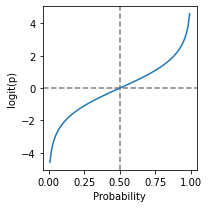

In [30]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

### **5.3.2 Logistic Regression and the GLM**

The package _scikit-learn_ has a specialised class for `LogisticRegression`. _Statsmodels_ has a more general method based on generalized linear model (GLM).

In [31]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6380882883923482
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


Note that the intercept and coefficients are reversed compared to the R model.

In [32]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


_Not in book_ :
If you have a feature or outcome variable that is ordinal, use the scikit-learn `OrdinalEncoder` to replace the categories (here, 'paid off' and 'default') with numbers. In the below code, we replace 'paid off' with 0 and 'default' with 1. This reverses the order of the predicted classes and as a consequence, the coefficients will be reversed.

In [33]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, 
             index=X.columns)

intercept  1.6380885430318344
classes [0. 1.]


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


### **5.3.4 Predicted Values from Logistic Regression**

In [34]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=loan_data[outcome].cat.categories)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757850     -0.760423
std        0.378032      0.390419
min       -2.768873     -3.538865
25%       -0.985728     -0.977164
50%       -0.697366     -0.688946
75%       -0.472209     -0.467076
max       -0.029476     -0.064787


In [35]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757850     -0.760423
std        0.378032      0.390419
min       -2.768873     -3.538865
25%       -0.985728     -0.977164
50%       -0.697366     -0.688946
75%       -0.472209     -0.467076
max       -0.029476     -0.064787


In [36]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500001      0.499999
std        0.167336      0.167336
min        0.062733      0.029046
25%        0.373167      0.376377
50%        0.497895      0.502105
75%        0.623623      0.626833
max        0.970954      0.937267


### **5.3.5 Interpreting the Coefficients and Odds Ratios**

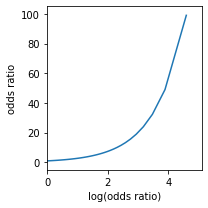

In [37]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

### **5.3.7 Assessing the Model**

For comparison, here the GLM model using _statsmodels_. This method requires that the outcome is mapped to numbers.

In [38]:
# use GLM (general linear model) with the binomial family to 
# fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Wed, 02 Feb 2022   Deviance:                       57515.
Time:                        06:59:48   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

Use splines.

In [39]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Wed, 02 Feb 2022   Deviance:                       57462.
Time:                                               06:59:49   Pearson chi2:                 4.54e+04
No. Iterations:                                            6                                         
Covariance Type:                                   nonrobust                      

In [40]:
from statsmodels.genmod.generalized_linear_model import GLMResults

def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()

    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0

    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)

    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial / 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    
    return ax

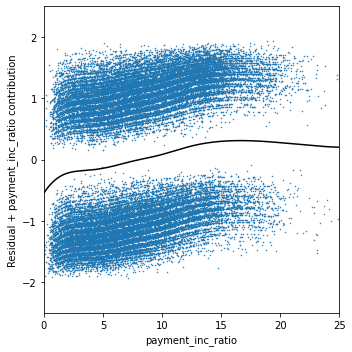

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

In [42]:
results.params

Intercept                         1.575614
purpose_[T.debt_consolidation]    0.248631
purpose_[T.home_improvement]      0.409708
purpose_[T.major_purchase]        0.238236
purpose_[T.medical]               0.520559
purpose_[T.other]                 0.628437
purpose_[T.small_business]        1.224953
home_[T.OWN]                      0.049812
home_[T.RENT]                     0.157661
emp_len_[T. > 1 Year]            -0.352614
bs(payment_inc_ratio, df=8)[0]    0.704167
bs(payment_inc_ratio, df=8)[1]    0.662121
bs(payment_inc_ratio, df=8)[2]    0.811784
bs(payment_inc_ratio, df=8)[3]    1.037710
bs(payment_inc_ratio, df=8)[4]    1.190148
bs(payment_inc_ratio, df=8)[5]    2.840399
bs(payment_inc_ratio, df=8)[6]   -1.342667
bs(payment_inc_ratio, df=8)[7]    7.109363
bs(borrower_score, df=3)[0]      -2.901130
bs(borrower_score, df=3)[1]      -2.605644
bs(borrower_score, df=3)[2]      -5.742075
dtype: float64

In [43]:
zero_params = results.params.copy()

# set model parametes of other features to 0
for i, name in enumerate(zero_params.index):
    if 'payment_inc_ratio' in name:
        continue
    zero_params[i] = 0.0

zero_params

Intercept                         0.000000
purpose_[T.debt_consolidation]    0.000000
purpose_[T.home_improvement]      0.000000
purpose_[T.major_purchase]        0.000000
purpose_[T.medical]               0.000000
purpose_[T.other]                 0.000000
purpose_[T.small_business]        0.000000
home_[T.OWN]                      0.000000
home_[T.RENT]                     0.000000
emp_len_[T. > 1 Year]             0.000000
bs(payment_inc_ratio, df=8)[0]    0.704167
bs(payment_inc_ratio, df=8)[1]    0.662121
bs(payment_inc_ratio, df=8)[2]    0.811784
bs(payment_inc_ratio, df=8)[3]    1.037710
bs(payment_inc_ratio, df=8)[4]    1.190148
bs(payment_inc_ratio, df=8)[5]    2.840399
bs(payment_inc_ratio, df=8)[6]   -1.342667
bs(payment_inc_ratio, df=8)[7]    7.109363
bs(borrower_score, df=3)[0]       0.000000
bs(borrower_score, df=3)[1]       0.000000
bs(borrower_score, df=3)[2]       0.000000
dtype: float64

## **5.4 Evaluating Classification Models**
### **5.4.1 Confusion Matrix**

In [44]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


In [45]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14336  8335]
 [ 8148 14523]]


Accuracy can easily be calculated using the _scikit-learn_ function `accuracy_score`.

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(true_y, pred_y)

0.6364739093996736

The package _dmba_ contains the function `classificationSummary` that prints confusion matrix and accuracy for a classification model.

In [47]:
classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


### **5.4.3 Precision, Recall, and Specificity**

In [48]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.6376089663760897
Recall 0.6323496978518812
Specificity 0.6405981209474659


The _scikit-learn_ function `precision_recall_fscore_support` returns
precision, recall, fbeta_score (F-measure) and support for each class.
> The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

> The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

> The support is the number of occurrences of each class in y_true.

In [49]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671]))

### **5.4.4 ROC Curve**

The function `roc_curve` in _Scikit-learn_ calculates all the information that is required for plotting a ROC curve.

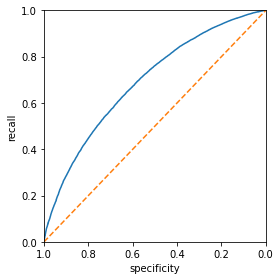

In [50]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1), '--')
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

plt.tight_layout()
plt.show()

https://www.biostat.wisc.edu/~page/rocpr.pdf

### **5.4.5 AUC**

AUC can easily be calculated using the _scikit-learn_ function `roc_auc_score`.

In [51]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.691710795288669
0.6917108731135808


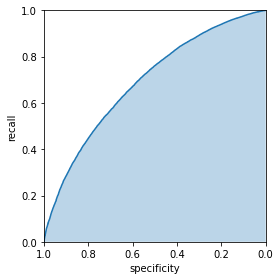

In [52]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)    # ax.fill_between(x, y1, y2)

plt.tight_layout()
plt.show()

## **5.5 Strategies for Imbalanced Data**
### **5.5.1 Undersampling**
> The results differ from the R version, however are equivalent to results obtained using the R code. Model based results are of similar magnitude.

In [53]:
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)
print(full_train_set.shape)

(119987, 19)


In [54]:
# print('percentage of loans in default: ', 
# print(      100 * np.mean(full_train_set.outcome == 'default')))
print('percentage of loans in default: ', 
      100 * np.mean(full_train_set.outcome == 'default'))

percentage of loans in default:  18.894546909248504


In [55]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
# print('percentage of loans predicted to default: ', 
# print(      100 * np.mean(full_model.predict(X) == 'default')))
print('percentage of loans predicted to default: ', 
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default:  0.9759390600648404


In [56]:
X.head()

,payment_inc_ratio,dti,revol_bal,revol_util,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,OWN,RENT,> 1 Year
0,8.14350,27.65,13648.0,83.7,0,0,0,0,0,0,0,1,1
1,2.39320,1.00,1687.0,9.4,0,0,1,0,0,0,0,1,1
2,8.25955,8.72,2956.0,98.5,0,0,0,0,0,1,0,1,1
3,8.27585,20.00,5598.0,21.0,0,0,0,0,1,0,0,1,1
4,5.21533,11.20,7963.0,28.3,0,0,0,0,1,0,0,1,1


In [57]:
(np.mean(full_train_set.outcome == 'default') / 
 np.mean(full_model.predict(X) == 'default'))

19.360375747224595

In [58]:
print(np.mean(full_train_set.outcome == 'default'))
print(np.mean(full_model.predict(X) == 'default'))

0.18894546909248502
0.009759390600648404


### **5.5.2 Oversampling and Up/Down Weighting**

In [59]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, sample_weight=wt)
# print('percentage of loans predicted to default (weighting): ', 
# print(      100 * np.mean(full_model.predict(X) == 'default')))
print('percentage of loans predicted to default (weighting): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting):  61.79836148916132


### **5.5.3 Data Generation**

The package _imbalanced-learn_ provides an implementation of the _SMOTE_ and similar algorithms.

In [60]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans in default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  29.484860859926492


In [61]:
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
# print('percentage of loans predicted to default (ADASYN): ', 
# print(      100 * np.mean(full_model.predict(X) == 'default')))
print('percentage of loans predicted to default (ADASYN): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans in default (ADASYN resampled):  48.56040383751355
percentage of loans predicted to default (ADASYN):  27.855517681082116


### **5.5.5 Exploring the Predictions**

In [62]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)

## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


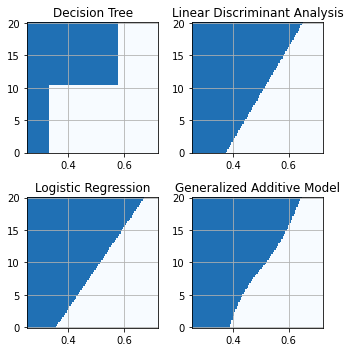

In [63]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = np.c_[xx.ravel(), yy.ravel()]

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:    
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

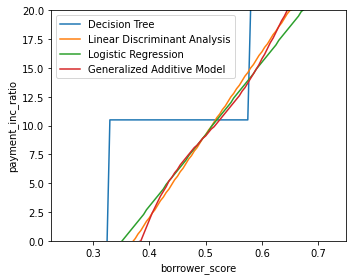

In [64]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()

https://www.svds.com/tbt-learning-imbalanced-classes/   
https://jair.org/index.php/jair/article/view/10302   
https://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/